In [1]:
import importlib as imp
import spotiphy
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import seaborn as sns
import anndata as ad
from collections import defaultdict
import cv2
from tqdm import tqdm

In [2]:
results_folder = 'results/CosMx/'
exp_df = pd.read_csv('F:/Ziqian Zheng/Spotiphy_data/CosMx/Raw_data_MsBrain/R5539_Ms1AB/R5539_Ms1AB_exprMat_file.csv')
exp_df = exp_df[exp_df['cell_ID'] != 0]
meta_df = pd.read_csv('F:/Ziqian Zheng/Spotiphy_data/CosMx/Raw_data_MsBrain/R5539_Ms1AB/R5539_Ms1AB_metadata_file.csv')
assert np.all(exp_df['cell_ID'].values == meta_df['cell_ID'].values)
adata_cos = ad.AnnData(exp_df.iloc[:, 2:])
meta_df.index = adata_cos.obs_names
adata_cos.obs = meta_df
adata_cos_orig = adata_cos.copy()
del exp_df, meta_df
loc_fov = pd.read_csv('F:/Ziqian Zheng/Spotiphy_data/CosMx/Raw_data_MsBrain/R5539_Ms1AB/R5539_Ms1AB_fov_positions_file.csv', index_col=0).values
loc_nucleus = adata_cos.obs[['CenterX_global_px', 'CenterY_global_px']].values

meta = pd.read_excel('F:/Ziqian Zheng/Spotiphy_data/CosMx/CosMx_meta_labels.xlsx', index_col=None)
meta['Sample'] = [i[:2] for i in meta['ID']]
meta['ID_fov'] = [i[3:] for i in meta['ID']]
meta = meta[meta['Sample']=='AB']
celltype_anno = defaultdict(str)
for c1, c2 in zip(meta['ID_fov'], meta['labels']):
    celltype_anno[c1] = c2
adata_cos.obs['ID_fov'] = [str(c1)+'_'+str(c2) for c1, c2 in zip(adata_cos.obs['cell_ID'], adata_cos.obs['fov'])]
adata_cos.obs['celltype'] = adata_cos.obs['ID_fov'].map(celltype_anno)
# type_list = sorted(list(adata_cos.obs['celltype'].unique()))
tx = pd.read_csv('F:/Ziqian Zheng/Spotiphy_data/CosMx/Raw_data_MsBrain/R5539_Ms1AB/R5539_Ms1AB_tx_file.csv')
polygon = pd.read_csv('F:/Ziqian Zheng/Spotiphy_data/CosMx/Raw_data_MsBrain/R5539_Ms1AB/R5539_Ms1AB-polygons.csv')
# polygon_size = polygon.groupby(['fov', 'cellID']).apply(lambda group: pd.Series({
#     'x_diff': group['x_local_px'].max() - group['x_local_px'].min(),
#     'y_diff': group['y_local_px'].max() - group['y_local_px'].min()
# })).reset_index()
# print(polygon_size.mean())

anndata.py (117): Transforming to str index.


In [3]:
adata_cos.obs['celltype'].value_counts()

celltype
               2005
L6 CT CTX      1940
Oligo          1659
Endo           1178
L5 PT CTX      1143
L6b CTX        1129
SUB            1051
L5/6 IT CTX    1049
Astro           993
L5 IT CTX       651
L5/6 NP CTX     636
Microglia       550
DG              457
CA              444
Vip             381
Pvalb           368
Sst Chodl       368
Neutrophil      367
Sncg            350
BCell           338
L4/5 IT CTX     335
Macrophage      308
TCell           301
L4 IT CTX       218
L2/3 IT CTX     213
Sst             198
L6 IT CTX       164
Lamp5            92
Name: count, dtype: int64

In [4]:
with open("results/AD sample 221/type_list.txt", "r") as file:
    type_list = [line.strip() for line in file.readlines()]
colors = np.array(list(plt.get_cmap("tab20b").colors) + list(plt.get_cmap("tab20c").colors))
colors = (colors*255).astype(np.int32)
color_dict = {type_: list(colors[i]) for i, type_ in enumerate(type_list)}

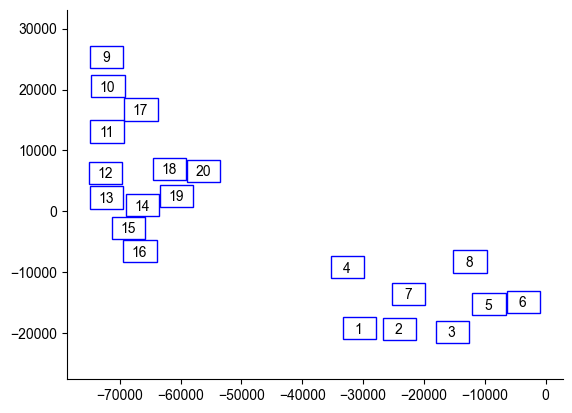

In [5]:
fig, ax = plt.subplots()
# plt.scatter(loc_nucleus[:, 0], loc_nucleus[:, 1], s=1)
# plt.scatter(loc_fov[:, 0], loc_fov[:, 1])

for i in range(len(loc_fov)):
    if i<9:
        plt.text(loc_fov[i, 0]+2000, loc_fov[i, 1]+1000, i+1, color='Black')
    else:
        plt.text(loc_fov[i, 0]+1400, loc_fov[i, 1]+1000, i+1, color='Black')
    fov_box = Rectangle((loc_fov[i]), 5472, 3648, facecolor='none', edgecolor='blue')
    ax.add_patch(fov_box)
sns.despine(top=True, right=True)
plt.axis('equal')
plt.gca().yaxis.grid(False)
plt.gca().xaxis.grid(False)
plt.gca().spines['left'].set_color('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().tick_params(left=True, axis='y', colors='black')
plt.gca().tick_params(bottom=True, axis='x', colors='black')
plt.savefig(results_folder+'fov_location.jpg')

In [ ]:
for fov in range(1, 21):
    polygon_temp = polygon[polygon['fov']==fov]
    img_seg = np.zeros((3648, 5472, 3))
    n_nucleus = np.max(polygon_temp['cellID'].unique())
    for i in polygon_temp['cellID'].unique():
        v = polygon_temp[polygon_temp['cellID']==i][['x_local_px', 'y_local_px']].values
        v = v.reshape((-1, 1, 2))
        i_int = int(i)
        img_seg = cv2.fillPoly(img_seg, [v], (i_int, i_int, i_int))
    img_seg = img_seg[:, :, 0].astype(np.int32)
    nucleus_pixels = {i+1:[] for i in range(n_nucleus)}
    for i in range(len(img_seg)):
        for j in range(len(img_seg[0])):
            if img_seg[i, j] > 0:
                nucleus_pixels[img_seg[i, j]] += [[i, j]]
    nucleus_location = np.zeros((n_nucleus, 2))
    for i in range(n_nucleus):
        nucleus_location[i] = np.mean(np.array(nucleus_pixels[i+1]), axis=0)
    nucleus_location = nucleus_location.astype(np.int32)
    nucleus_location = nucleus_location[:, [1, 0]]
    search_direction = [[1, 0], [0, 1], [-1, 0], [0, -1], [2, 0], [0, 2], [-2, 0], [0, -2], [1, 1], [-1, 1], [-1, -1], [1, -1]]
    boundary_dict = spotiphy.segmentation.cell_boundary(nucleus_location, img_seg.shape[:2], 80, max_area=22000, verbose=0, search_direction=search_direction,
                                                        delta=5)
    with open(results_folder+f'segmentation/boundary_dict_{fov}.pkl', 'wb') as f:
        pickle.dump(boundary_dict, f)
    # To load the dictionary:
    # with open(results_folder+f'segmentation/boundary_dict_{fov}.pkl', 'rb') as f:
    #     boundary_dict = pickle.load(f)

 58%|█████▊    | 2105/3648 [02:12<01:14, 20.59it/s]

In [ ]:
for fov in range(1, 21):
    with open(results_folder+f'segmentation/boundary_dict_{fov}.pkl', 'rb') as f:
        boundary_dict = pickle.load(f)
    polygon_temp = polygon[polygon['fov']==fov]
    select_cell_list = []
    for i in polygon_temp['cellID'].unique():
        if celltype_anno[str(i)+'_'+str(fov)] in color_dict.keys():
            select_cell_list += [i]
    img = np.zeros((3648, 5472, 3)).astype(np.int32)
    l = 3  # Width of the boundary/2
    for i in select_cell_list:
        v = polygon_temp[polygon_temp['cellID']==i][['x_local_px', 'y_local_px']].values
        v = v.reshape((-1, 1, 2))
        color = [int(i) for i in color_dict[celltype_anno[str(i)+'_'+str(fov)]]]
        img = cv2.fillPoly(img, [v], color)
        cell_boundary = boundary_dict['individual_boundary'][i]
        for pixel in cell_boundary:
            img[pixel[0]-l:pixel[0]+l+1, pixel[1]-l:pixel[1]+l+1] = [200, 200, 200]
    fig, ax = plt.subplots(dpi=600)
    plt.imshow(img)
    ax.axis('off')
    plt.savefig(results_folder+'Figure2/'+str(fov)+'.png')

In [ ]:
remove_list = ['', 'DAM', 'Activated', 'Glu', 'GABA', 'Oligo']
for i in remove_list:
    if i in palette_dict.keys():
        del palette_dict[i]
gene = ['Agt', 'Slc6a11', 'Tcf7l2', 'Fgf1']
# gene = ['Tcf7l2', 'Fgf1']
palette_dict_gene = {'Agt':(0.43, 0.83, 0.64), 'Slc6a11':(0.24, 0.55, 0.81), 'Tcf7l2':(0.96, 0.13, 0.18), 'Fgf1':(1, 0, 0.98)}
# palette_dict_gene = {'Tcf7l2':(0.43, 0.83, 0.64), 'Fgf1':(0.24, 0.55, 0.81)}
for fov in tqdm(range(1, 21)):
    tx_temp = tx[tx['fov']==fov]
    tx_temp = tx_temp[tx_temp['target'].isin(gene)]
    # tx_temp = tx_temp[::10]
    polygon_temp = polygon[polygon['fov']==fov]
    img = np.zeros((3648, 6800, 3))
    for i in polygon_temp['cellID'].unique():
        if celltype_anno[str(i)+'_'+str(fov)] in remove_list:
            continue
        v = polygon_temp[polygon_temp['cellID']==i][['x_local_px', 'y_local_px']].values
        v = v.reshape((-1, 1, 2))
        color = palette_dict[celltype_anno[str(i)+'_'+str(fov)]]
        img = cv2.fillPoly(img, [v], color)
    fig, ax = plt.subplots(dpi=600)
    plt.imshow(img)
    for i, (name, color) in enumerate(palette_dict.items()):
        ax.add_patch(patches.Rectangle((5700, i*200+600), 500, 200, facecolor=color, edgecolor='none'))
        ax.text(6300, i*200+700, name, va="center", ha="left", fontsize=5, color='white')
    for i, (name, color) in enumerate(palette_dict_gene.items()):
        ax.add_patch(patches.Rectangle((5700, i*200+2600), 500, 200, facecolor=color, edgecolor='none'))
        ax.text(6300, i*200+2700, name, va="center", ha="left", fontsize=5, color='white')
    ax.axis('off')
    plt.scatter(tx_temp['x_local_px'], tx_temp['y_local_px'], color=tx_temp['target'].map(palette_dict_gene), s=1)
    plt.savefig(results_folder+'Figure1/'+str(fov)+'.png')

In [216]:
tx['fov'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20], dtype=int64)

In [149]:
tx_temp.head(100)

,fov,cell_ID,x_global_px,y_global_px,x_local_px,y_local_px,z,target,CellComp
0,1,0,-32107.874444,-17979.683333,1236.57,3103.650,-3,Lpin1,0
1,1,0,-31632.144444,-18517.603333,1712.30,2565.730,-3,Sv2b,0
2,1,0,-32480.594444,-19122.433333,863.85,1960.900,-3,Gabrb3,0
3,1,0,-27983.804444,-19131.353333,5360.64,1951.980,-3,Gpm6a,0
4,1,0,-27978.864444,-19132.013333,5365.58,1951.320,-3,Slc17a7,0
...,...,...,...,...,...,...,...,...,...
95,1,0,-28701.514444,-17892.819333,4642.93,3190.514,-2,Phc3,0
96,1,0,-28720.594444,-17893.496333,4623.85,3189.837,-2,Slc12a2,0
97,1,0,-28340.254444,-17895.843333,5004.19,3187.490,-2,Maged1,0
98,1,0,-28703.544444,-17897.408333,4640.90,3185.925,-2,Samhd1,0


In [31]:
DE = pd.read_excel(results_folder+'outer_inner_DEtd3.xlsx')
gene_list = list(DE['ID'])
n_molecule = np.zeros((len(gene_list), 20))
n_astro = np.zeros(20)
mean_exp = np.zeros((len(gene_list), 2))
for fov in range(1, 21):
    adata_cos_temp = adata_cos[adata_cos.obs['fov']==fov]
    adata_cos_temp = adata_cos_temp[adata_cos_temp.obs['celltype']=='Astro']
    n_astro[fov-1] = len(adata_cos_temp)
    tx_temp0 = tx[tx['fov']==fov]
    select_cell_list = []
    for i in tx_temp0['cell_ID'].unique():
        if celltype_anno[str(i)+'_'+str(fov)] == 'Astro':
            select_cell_list += [i]
    tx_temp0 = tx_temp0[tx_temp0['cell_ID'].isin(select_cell_list)]
    for i, gene in tqdm(enumerate(gene_list)):
        tx_temp = tx_temp0[tx_temp0['target']==gene]
        n_molecule[i, fov-1] = len(tx_temp)

568it [00:01, 424.79it/s]
568it [00:01, 414.73it/s]
568it [00:01, 405.39it/s]
568it [00:01, 449.87it/s]
568it [00:01, 375.26it/s]
568it [00:01, 401.82it/s]
568it [00:00, 597.22it/s]
568it [00:01, 333.90it/s]
568it [00:01, 469.98it/s]
568it [00:01, 506.19it/s]
568it [00:00, 588.27it/s]
568it [00:01, 517.04it/s]
568it [00:01, 534.57it/s]
568it [00:01, 412.02it/s]
568it [00:00, 693.47it/s]
568it [00:01, 538.31it/s]
568it [00:01, 426.57it/s]
568it [00:01, 540.66it/s]
568it [00:01, 494.10it/s]
568it [00:00, 726.73it/s]


In [33]:
# in_out = [np.array([8, 9, 10, 11, 12]), np.array([17, 18, 19])]
in_out = [np.array([0, 1, 2]), np.array([7])]
for i in range(len(gene_list)):
    for j in range(2):
        mean_exp[i, j] = np.sum(n_molecule[i, in_out[j]])/np.sum(n_astro[in_out[j]])
DE['in_1'] = mean_exp[:, 0]
DE['out_1'] = mean_exp[:, 1]
DE['diff_1'] = mean_exp[:, 0] - mean_exp[:, 1]
DE['logFC_cosMX_1'] = np.log(mean_exp[:, 0]/mean_exp[:, 1])

620352914.py (9): invalid value encountered in true_divide


In [34]:
DE.to_csv(results_folder+'outer_inner_DE_analysis_onlyastro.csv')

<Axes: xlabel='logFC', ylabel='logFC_cosMX_1'>

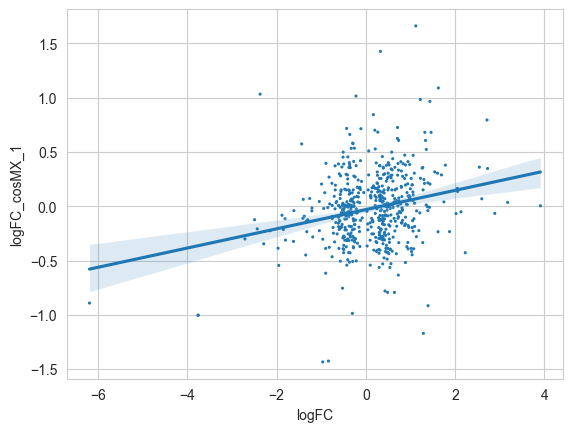

In [39]:
sns.scatterplot(data=DE, x='logFC', y='logFC_cosMX_1', edgecolor='none', s=5)
sns.regplot(data=DE, x='logFC', y='logFC_cosMX_1', scatter=False)

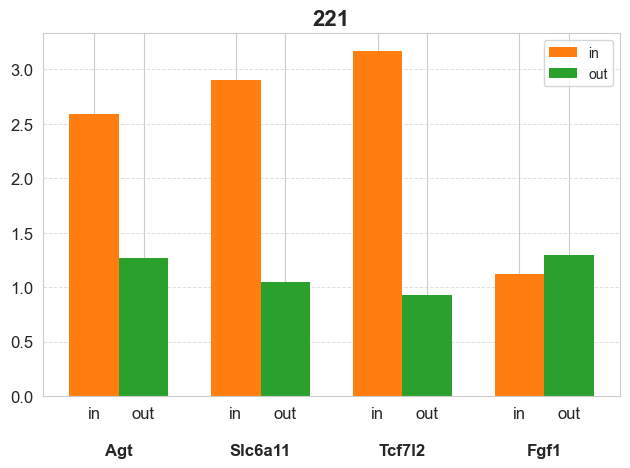

In [8]:
df = pd.DataFrame({'in':mean_exp[:, 1], 'out':mean_exp[:, 0]}, index=gene_list)

colors = ['#ff7e0f', '#2aa12c']

barWidth = 0.35
r1 = np.arange(len(df['in']))
r2 = [x + barWidth for x in r1]

# Plot the bars
plt.bar(r1, df['in'], color=colors[0], width=barWidth, label='in', edgecolor='none')
plt.bar(r2, df['out'], color=colors[1], width=barWidth, label='out', edgecolor='none')

# Position gene names in the middle of the corresponding bars
for i in r1:
    plt.text(i + barWidth / 2, -0.5, df.index[i], ha='center', va='center', fontsize=12, fontname='Arial', fontweight='bold')

group_labels = ['in'] * len(df.index) + ['out'] * len(df.index)
plt.xticks(np.concatenate((r1, r2)), group_labels, fontsize=12, fontname='Arial', rotation=0)

plt.title('221', fontsize=16, fontweight='bold', fontname='Arial')
plt.yticks(fontsize=12, fontname='Arial')
plt.tight_layout()

plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6)

plt.legend()
plt.savefig(results_folder+'221_astro_inout.png')
plt.show()